## Example workflow using Delft3D-Flexible Mesh unstructured grid for an unsteady flow field
#### Caitlin R. R. Turner, July 2025

This workbook provides an example workflow for simulating particle movement in an unsteady flow field using hydrodynamic outputs from the [Delft3D-Flexible Mesh (Delft3DFM)](https://www.deltares.nl/en/software/delft3d-flexible-mesh-suite/) suite. Delft3DFM solves the Navier–Stokes equations for incompressible fluids using the shallow water and Boussinesq approximations via a cell-centered finite volume method.

To demonstrate this functionality, the workbook walks through calculations of **water exposure time** for the **Lake Pontchartrain Estuary** in Louisiana (USA). Outputs from a previous model run are provided as text files in the repository.

For Delft3DFM flow fields stored in a `.nc` file, a commented-out code block is included below to show how relevant variables can be extracted and formatted for use as *dorado* inputs.

**Note:** This workbook is modeled after `unstructured_grid_anuga.ipynb` by Kyle Wright and Jay Jariharan, which provides a thorough walkthrough of the geospatial functions in `particle_track.py` and others in `routines.py`, including guidance on computing exposure times for a region of interest. Please refer to that notebook for detailed information on the underlying functions and methodology.

### Import necessary dependencies

In [1]:
try:
    import pandas as pd
    import xarray as xr
    from pyproj import Proj
except ImportError:
    # Install missing packages
    import sys
    !{sys.executable} -m pip install pandas xarray pyproj
    import pandas as pd
    import xarray as xr
    from pyproj import Proj

import os
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import json
import dorado
import dorado.particle_track as pt

#### Download Necessary Files and Define Folders
To use this notebook, the data folder **D3DFM_example_required_files** needs to be downloaded from HydroShare which can be found [here](https://doi.org/10.4211/hs.2301e151c62d4febb59655885458ab0c). Download the folder into your work folder and copy the path into the variable `data_folder_path` below.

In [2]:
data_folder = Path(r"Documents/D3DFM_example_required_files") # Change to your path
model_run = "run_01"

path2folder = data_folder / model_run
path2folder.mkdir(parents=True, exist_ok=True)

#### Load Delft3D Model Files
If we were starting directly from a Delft3DFM output file, this is where we would import the outputs from the model run. These files are included in the HydroShare folder; however, for anyone interested in repeating the steps used to generate these files, uncomment the block of code below.

Here, `path2file` should point to the Delft3D-FM map output file (e.g., `./FlowFM_map.nc`). This file is a NetCDF dataset containing model results. The following variables are required, with their corresponding Delft3D-FM names shown in brackets:
- `x_face` [`mesh2d_face_x`]: x-coordinate of face centers (longitude, float array)  
- `y_face` [`mesh2d_face_y`]: y-coordinate of face centers (latitude, float array)  
- `elevation` [`mesh2d_flowelem_bl`]: bed elevation (float array)  
- `time` [`time`]: model output times (float or datetime array)  
- `stage` [`mesh2d_s1`]: water surface elevation (2D array: time × face)  
- `depth` [`mesh2d_waterdepth`]: total water depth from bed (2D array: time × face)  
- `u` [`mesh2d_ucx`]: velocity component in the x-direction (2D array: time × face)  
- `v` [`mesh2d_ucy`]: velocity component in the y-direction (2D array: time × face)  


These are defined by the latitude and longitude of each cell center. In our case, those coordinates are expressed in **decimal degrees**, which will be relevant later. 

The model used in this notebook is a toy model of Lake Pontchartrain (USA) that was created in Delft3D. This toy model can be found [here](https://doi.org/10.4211/hs.2301e151c62d4febb59655885458ab0c) (Turner, 2025),  which is used for this walkthorugh (downloading this is not necessary, but may be helpful when for learning how to apply *dorado* to Delft3D models). A fully calibrated model can be found [here](https://doi.org/10.4211/hs.f1c83ff830bb47c5a7c84e6f5217ea5c) (Turner & Hiatt, 2025b), with the model creation process and applications of these codes outlined in *Water exposure time distributions controlled by freshwater releases in a semi-enclosed estuary* (Turner & Hiatt, 2025a).

In [3]:
# # How to convert Delft3DFM outputs to dorado inputs
# map_xr = xr.open_dataset(data_folder / "FlowFM_map.nc")
# x = map_xr['mesh2d_face_x'].values.astype(np.float32).tolist()
# y = map_xr['mesh2d_face_y'].values.astype(np.float32).tolist()
# elevation = map_xr['mesh2d_flowelem_bl'].values.astype(np.float32).tolist()
# time = map_xr['time'].values.astype(np.float32).tolist()

# unstructured = {
#     'time': time[1:], 'elevation': elevation,
#     'x_face': x, 'y_face': y,
#     'timesteps': []}
# for i in range(len(time) - 1):
#     stage = map_xr['mesh2d_s1'].isel(time=1 + i).values.astype(np.float32)
#     depth = map_xr['mesh2d_waterdepth'].isel(time=1 + i).values.astype(np.float32)
#     u     = map_xr['mesh2d_ucx'].isel(time=1 + i).values.astype(np.float32)
#     v     = map_xr['mesh2d_ucy'].isel(time=1 + i).values.astype(np.float32)

#     timestep_data = [stage.tolist(), depth.tolist(), u.tolist(), v.tolist()]
#     unstructured['timesteps'].append(timestep_data)
    
# # Save as JSON
# with open(data_folder / f'unstructured_model_Delft3DFM_{model_run}.txt', 'w') as f:
#     json.dump(unstructured, f)

Here, we will skip the previous step and instead import the `unstructured_model_Delft3DFM.txt` dictionary directly from your working directory.  

In addition to the model folder, you will also need the land boundaries file, which we call `boundaries`. This file is located in your model inputs folder (e.g., `FlowFM/input/FlowFM.ldb`) and is typically stored in a Microsoft Access database format.  

In [4]:
unstructured = json.load(open(data_folder / f'unstructured_model_Delft3DFM_{model_run}.txt'))
boundaries = pd.read_csv(data_folder / "boundaries_latlon.csv") 

### Change Decimal Degree to UTM Projection

Some models are defined in decimal degrees, but UTM (meters) is more convenient for this workflow.

The example below converts Delft3D-FM outputs from geographic (latitude/longitude) to UTM. Choose the UTM zone (`zone`) for your domain. An easy website to find this zone can be found [here](https://mapscaping.com/utm-zone-finder/), where you select your domain location on a map. We will use `pyproj` to convert unstructured grid coordinates (`unstructured['y_face']`, `unstructured['x_face']`) and land-boundary coordinates (`boundaries['x']`, `boundaries['y']`) from decimal degrees (longitude, latitude) to UTM eastings (x) and northings (y).

In [5]:
# Define UTM Zone
utm_proj = Proj(proj='utm', zone=15, ellps='WGS84')

# Convert Unstructured Grid lon (unstructured['x_face']) and lat (unstructured['y_face']) to UTM
(unstructured['x'], unstructured['y']) = utm_proj(unstructured['x_face'], unstructured['y_face'])
unstructured['x'], unstructured['y'] = np.round(unstructured['x'], 2), np.round(unstructured['y'],2)

# Convert land boundaries lon (boundaries['x']) and lat (boundaries['y']) to UTM
boundaries['x'], boundaries['y'] = utm_proj(boundaries['x'], boundaries['y'])

### Convert data and coordinates for particle routing

Now that we have the necessary data, we can convert it into the format required by `dorado`. This process includes gridding the hydrodynamic outputs and transforming the geospatial coordinates into **array index** coordinates.

First, we will combine our $(x, y)$ coordinates into a list of tuples. This is the expected format for coordinate inputs in the following functions.

In [6]:
# Use list comprehension to convert into tuples
coordinates = [(round(float(x), 2), round(float(y), 2))for x, y in zip(unstructured['x'], unstructured['y'])]

# Let's see the extent of our domain
print(min(unstructured['x']), max(unstructured['x']), 
      min(unstructured['y']), max(unstructured['y']))
# As well as our number of data points
print(len(unstructured['x']))

745610.29 824870.19 3321450.24 3364099.54
2846


Now, let's grid our unstructured data onto a uniform grid. For this, we use the function `particle_track.unstruct2grid()`, which performs inverse-distance-weighted interpolation to generate a Cartesian grid that matches the spatial extent of our model.

To use this function, we need to provide:

- A list of coordinates (as tuples).
- The unstructured data to be gridded (in this case, we start with `elevation`).
- The desired resolution of the output grid (here, we use $100\,\text{m}$).
- The number of $k$ nearest neighbors to include in the interpolation.  
  - If $k = 1$, only the nearest data point is used.
  - Higher values (default is $k = 3$) produce smoother interpolated results.

The underlying implementation uses `scipy` to build a `cKDTree` from the unstructured input data, which maps data points onto a uniform array. While `cKDTree` is significantly faster than other gridding methods (e.g., `scipy.interpolate.griddata`), constructing the tree can still be computationally expensive for very large datasets or very fine grid resolutions.

The outputs of `unstruct2grid()` are:

- `myInterp`: the resulting interpolation function, which can be reused to grid additional datasets sharing the same coordinate system, grid resolution, and $k$.
- A gridded NumPy array of the interpolated data.


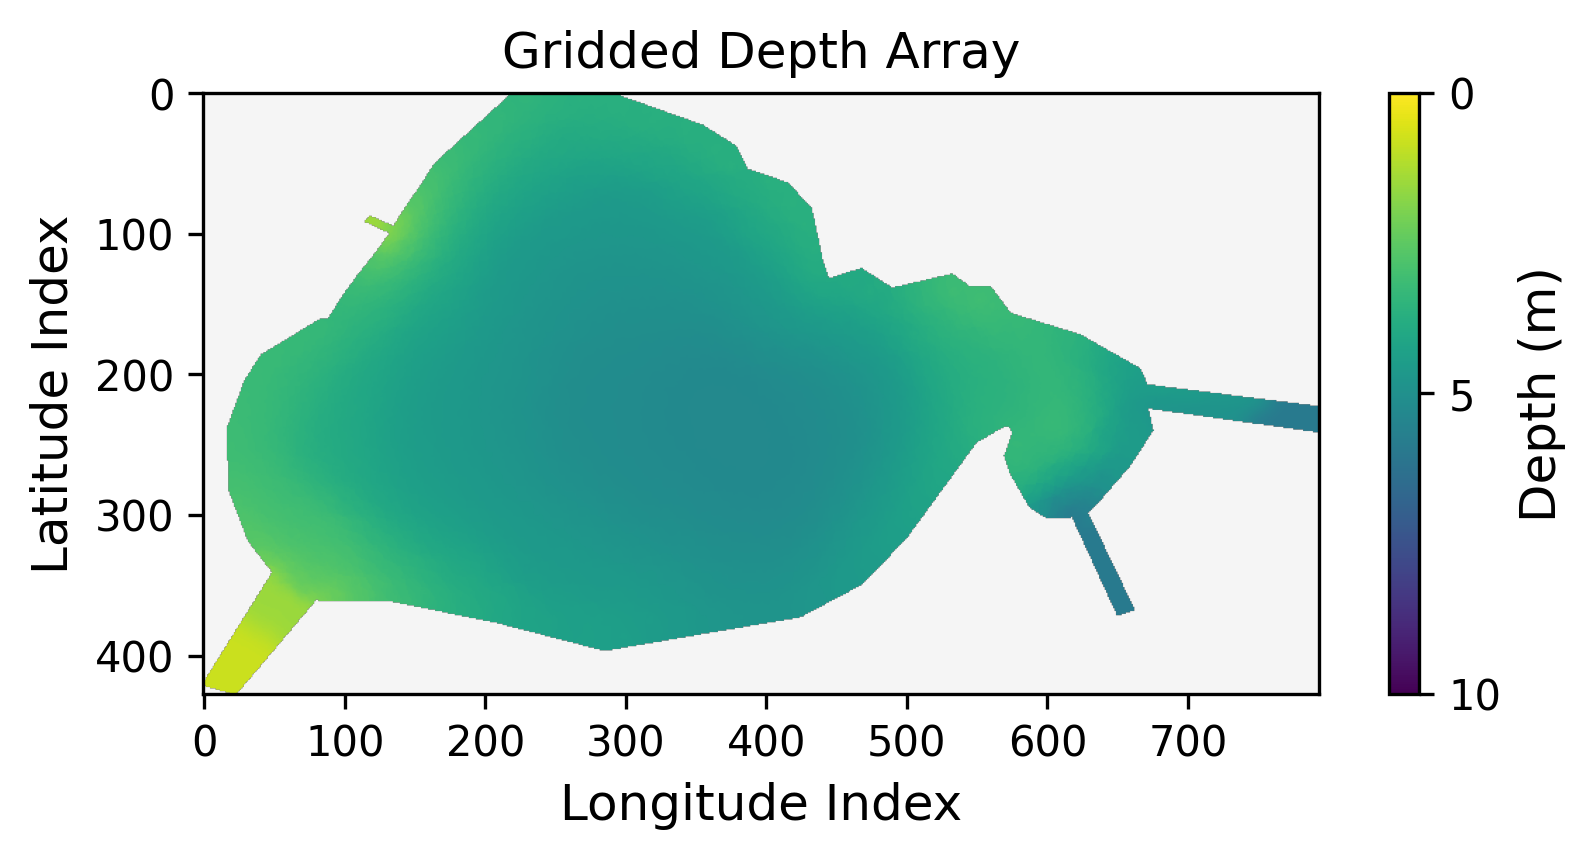

In [7]:
resolution = 100 # km
knn = 5 # nearest neighbors used
myInterp, elevation = pt.unstruct2grid(coordinates, unstructured['elevation'], resolution, knn, boundary=boundaries, crop=True)

# Let's plot the resulting grid to see what the output looks like:
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
cax = ax.imshow(elevation, vmin=-10, vmax=0)
cbar = fig.colorbar(cax, ax=ax, label='Depth (m)',shrink = 0.65)
ax.set_xlabel('Longitude Index', fontsize=12)
ax.set_ylabel('Latitude Index', fontsize=12)
cbar.ax.set_ylabel('Depth (m)', fontsize=12)
cbar.set_ticks([0, -5, -10])
cbar.set_ticklabels(['0', '5', '10'])
ax.set_facecolor('whitesmoke')
plt.title('Gridded Depth Array')
plt.show()

### Define Particle Locations

For this example, we aim to calculate the exposure time of **Lake Pontchartrain**. This means we want to seed particles throughout the entire basin. 

To inject particles at a specific location continuously over a set length of time, refer to the notebook `unstructured_grid_anuga.ipynb`.

First, we need to define gridcell types. Instructions for creating this file are provided in the commented-out code block below.

In [8]:
celltype_initial = np.genfromtxt(data_folder / "celltype_edges.csv", delimiter=',')
celltype = np.genfromtxt(data_folder / "celltype_roi.csv", delimiter=',')

# Note: Here is an example on how make this file.
# Run the code through gridded elevation, then run the following:
# cell_type_all = elevation.copy()
# cell_type_all[~np.isnan(cell_type_all)] = 1
# cell_type_all[np.isnan(cell_type_all)] = 2
# np.savetxt("required_files/cell_type_all.csv", cell_type_all.astype(int), delimiter = ",",fmt="%d")
#
# Next, go into the csv, and manually change the value of anywhere other than 
# the region you are investigating. You want to change the 1's to 2's in those spots.
# Excel conditional formating makes this task much easier. Make all values of 1 in the script blue.
# Then upload this data back here as celltype_roi.csv
# celltype = np.genfromtxt("required_files/celltype_roi.csv", delimiter = ",")
# celltype[np.isnan(celltype)] = 2

### Set Locations for Particles

Next, we define the possible locations where particles can be seeded.

In this example, particles are seeded only in grid cells marked as valid (i.e., where `celltype_lponly == 1`). These cells are typically used to represent water regions of interest—in this case, Lake Pontchartrain. We initialize a `regions` array of the same shape as `elevation`, which will mark eligible seeding zones.

The list `seed_locations` is populated with the `(i, j)` indices of all grid cells that meet the criteria. We then randomly shuffle this list and select a fraction (10%) of the locations to seed particles. This sampling reduces computational cost, especially for large grids.

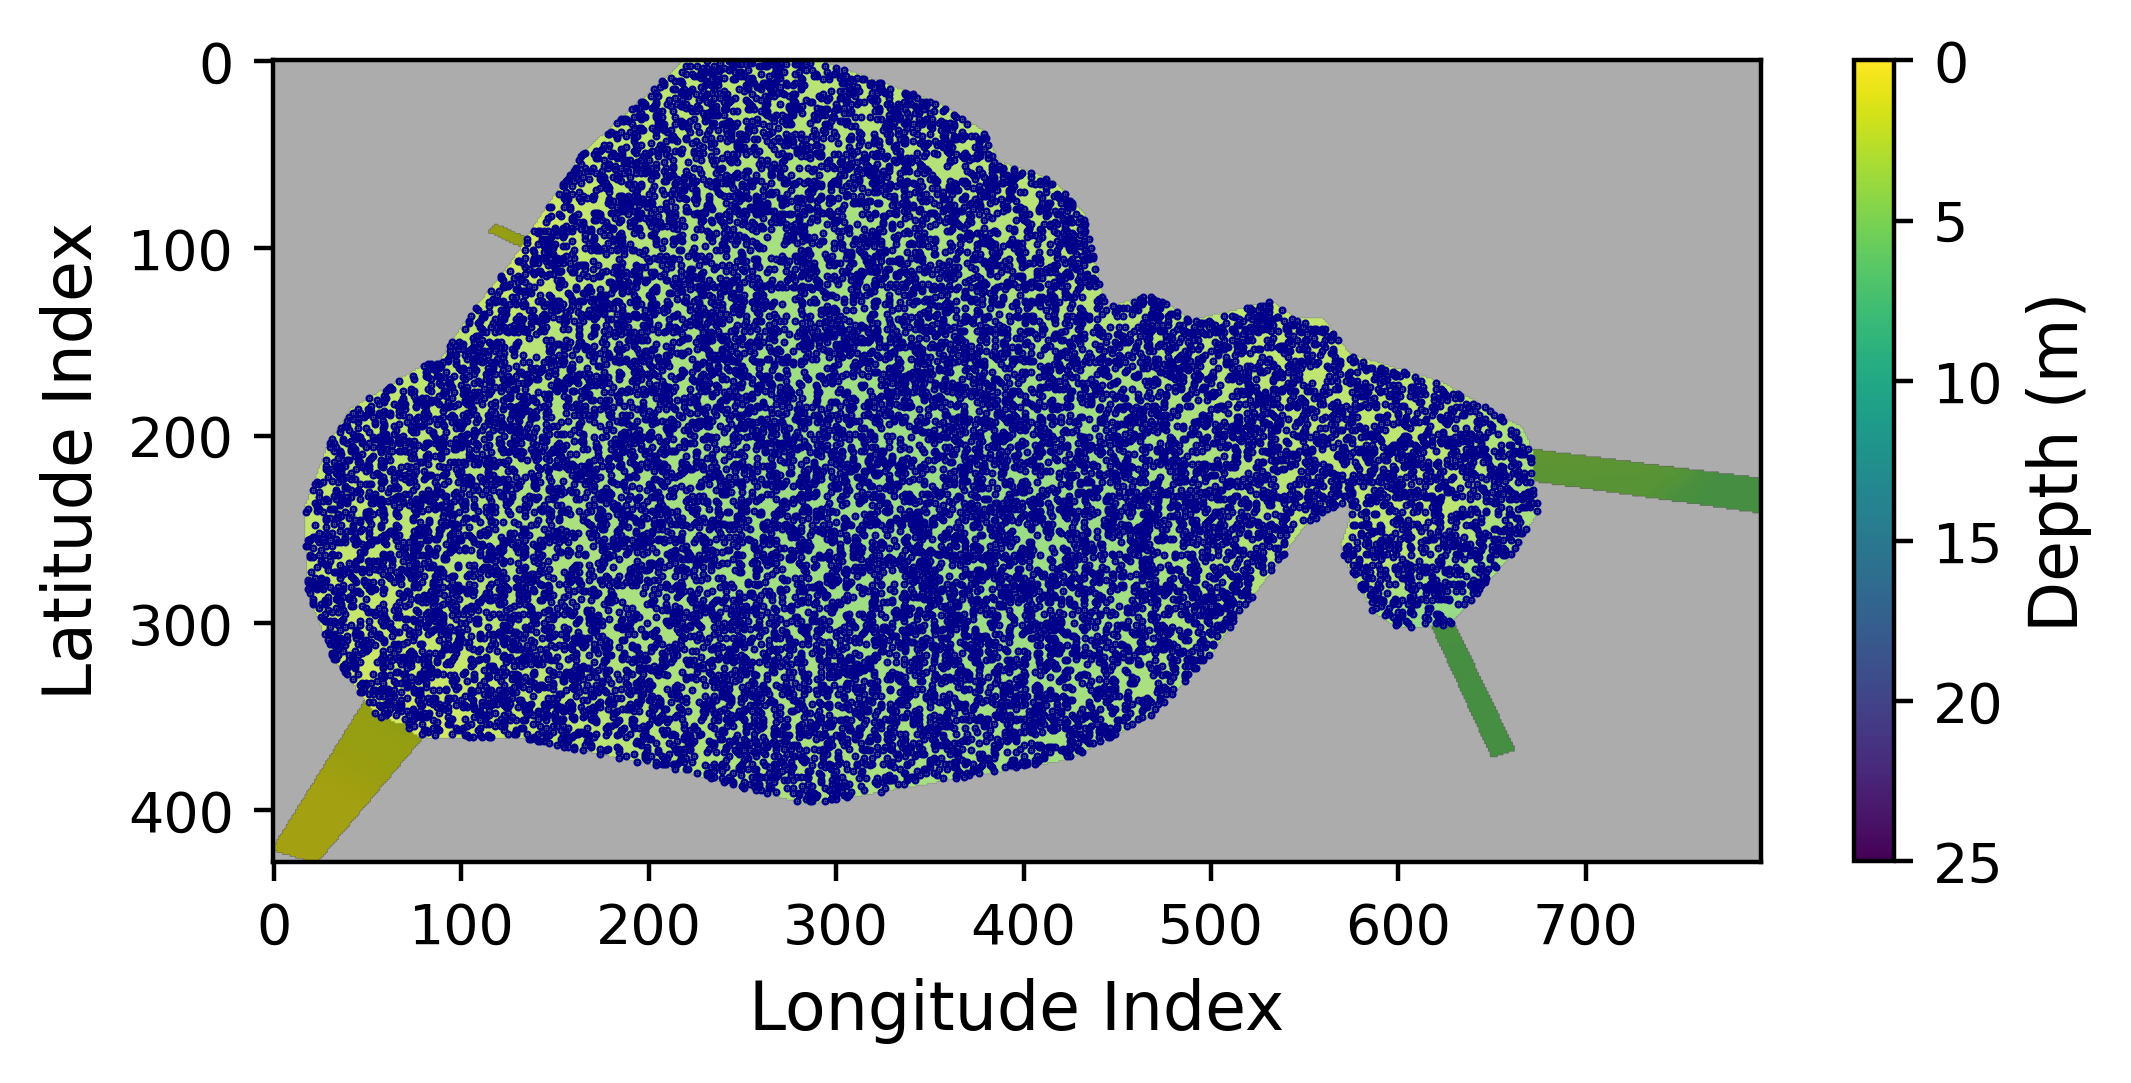

In [9]:
regions = np.zeros_like(elevation, dtype='int')

# Find all seed locations where celltype_roi == 1
seed_locations = np.argwhere(celltype == 1) 
regions[celltype == 1] = 1

# Identify possible locations to initialize particles. 
np.random.shuffle(seed_locations)
num_seeds = int(len(seed_locations) * 0.10) # This means that 10% of the cells have particles. 
                                            # For large grid sizes, make this number smaller.
                                            # It helps make it manageable

selected_seed_locations = seed_locations[:num_seeds]
seed_xloc, seed_yloc = zip(*selected_seed_locations)


fig, ax = plt.subplots(figsize=(6, 4), dpi=400)
cax = ax.imshow(elevation, vmin=-25, vmax=0)
plt.imshow(regions, cmap='bone', alpha=0.3)
plt.scatter(seed_yloc,seed_xloc, s = 0.2, color='darkblue')
cbar = fig.colorbar(cax, ax=ax, label='Depth (m)',shrink = 0.65)
ax.set_xlabel('Longitude Index', fontsize=12)
ax.set_ylabel('Latitude Index', fontsize=12)
cbar.ax.set_ylabel('Depth (m)', fontsize=12)
cbar.set_ticks([0, -5, -10, -15, -20, -25])
cbar.set_ticklabels(['0', '5', '10','15', '20','25'])
ax.set_facecolor('whitesmoke')
plt.show()


### Define model routing parameters

Now that we have pre-processed the input data, we can configure the particle routing model.

We do this using the `particle_track.modelParams` class, where we populate the relevant attributes to suit our application. This includes specifying the gridded hydrodynamic outputs generated earlier, the grid resolution `dx`, and various tuning parameters that influence the behavior of the random walk.

In this example, we use the default values for the random walk parameters: `gamma`, `theta`, and `diff_coeff`. Specifically, we keep at `theta = 1.0` to represent water, as we are interested in computing **water exposure time** within Lake Pontchartrain.

We are using 10000 particles. At least $O(10^3)$ are recommended depending on your grid size.


In [10]:
particles = 10000  
model_timestep = 3600 # seconds (There are 3600 seconds are in hours. The example model uses hourly outputs)
timesteps = (len(unstructured['time'])-1)

params = pt.modelParams()
params.theta = 1.0
params.gamma = 0.05
params.diff_coeff = 0.8
params.cell_type = np.where(np.isnan(elevation), 2, celltype_initial)
params.dx = resolution # 100 m in this case
params.dry_depth = 0.01
params.verbose = False

target_times = np.arange(0, model_timestep * (timesteps + 1), model_timestep)
target_times = [int(t) for t in target_times]
prev_counts = None # Initialize for particle timing

### Run the particle routing for unsteady flow fields

Because our model represents an unsteady case (i.e., the flow field varies with time), we initialize the particles at the first-time step and track their movement at each subsequent step. For details on steady flows and/or constant particle injections, refer to the notebook *unstructured_grid_anuga.ipynb*, which provides a thorough overview of the particle routing processes and workflow used in 'dorado'.

The output is stored in a dictionary organized into the keys `['xinds']`, `['yinds']`, and `['travel_times']`. These are first indexed by particle ID, and then by iteration number. For example, `walk_data['xinds'][5][10]` returns the x-index for the 6th particle at its 11th iteration. While this function returns a `walk_data` dictionary, the same information is also stored as an attribute of the `particles` class and can be accessed via `particle.walk_data`.

In [11]:
# # Running this may take up to 30 minutes. A copy of the results is provided below.
# for i in range(timesteps):
#     # Rasterize all data
#     stage = myInterp(unstructured['timesteps'][i][0])
#     depth = myInterp(unstructured['timesteps'][i][1])
#     u = myInterp(unstructured['timesteps'][i][2])
#     v = myInterp(unstructured['timesteps'][i][3])

#     # Set Dorado parameters
#     params.topography = elevation
#     params.stage = stage
#     params.qx = u * depth
#     params.qy = v * depth
#     params.u = u
#     params.y = v

#     # Generate particles
#     particle = pt.Particles(params)
#     if i == 0:
#         particle.generate_particles(particles, seed_xloc, seed_yloc, seed_time=0, method='exact')
#     else:
#         particle.generate_particles(0, [], [], previous_walk_data=walk_data)

#     # Run iteration
#     walk_data = particle.run_iteration(target_times[i])
#     xi, yi, ti = dorado.routines.get_state(walk_data)

#     # Discretely assign timesteps times since for unsteady flows with no new particles added
#     # This addresses that particles may move through multiple grid cells at each timestep
#     x_key = 'xinds' if 'xinds' in walk_data else 'x_inds'
#     t_key = 'travel_times'
#     x_lists = walk_data[x_key]
#     t_lists = walk_data.get(t_key, [[] for _ in x_lists])
#     walk_data[t_key] = t_lists
#     if prev_counts is None or len(prev_counts) != len(x_lists):
#         prev_counts = [0] * len(x_lists)    
#     t_start = target_times[i - 1] if i > 0 else 0
#     t_end   = target_times[i]
    
#     for p, x_list in enumerate(x_lists):
#         list_len = len(x_list)
#         added = list_len - prev_counts[p]
#         if added <= 0:
#             continue
            
#         # Determine starting time 
#         last_time = t_lists[p][prev_counts[p]-1] if prev_counts[p] > 0 else t_start
        
#         # Build segment from last_time to t_end
#         seg = np.linspace(last_time, t_end, added + 1, endpoint=True)[1:]
#         seg = [int(s) if s.is_integer() else float(s) for s in seg]
    
#         # Grow travel_times if particles move through multiple grid cells
#         # within one timestep
#         if len(t_lists[p]) < list_len:
#             t_lists[p].extend([None] * (list_len - len(t_lists[p])))
    
#         # Fill the list of timesteps
#         t_lists[p][prev_counts[p]:list_len] = seg
#         prev_counts[p] = list_len

#     # Plotting
#     fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
#     ax.scatter(yi, xi, c='firebrick', s=1)
#     im = ax.imshow(particle.depth * -1, vmin=0, vmax=-25)
#     plt.title(f'Time: {int((target_times[i] / 3600) // 24)} Days, {int((target_times[i] / 3600) % 24)} Hours')
#     cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#     cbar.set_label('Depth (m)')
#     cbar.set_ticks([0, -5, -10, -15, -20, -25])
#     cbar.set_ticklabels(['0', '5', '10', '15', '20', '25'])
#     im.axes.xaxis.set_ticklabels([])
#     im.axes.yaxis.set_ticklabels([])
#     im.axes.get_xaxis().set_ticks([])
#     im.axes.get_yaxis().set_ticks([])
#     ax.set_facecolor('whitesmoke')
#     plt.savefig(f'{path2folder}/output_by_dt{i}.png')
#     plt.close()

If you prefer not to run the code, a file containing the results can be found in this HydroShare [repository](https://doi.org/10.4211/hs.2301e151c62d4febb59655885458ab0c).


In [12]:
with open(data_folder / f'WalkData_{model_run}.txt', 'r') as f:
    walk_data = json.load(f)

Now that we have the walk history stored in `walk_data`, we can query this dictionary to extract features of interest. We can also convert the location indices back into geospatial coordinates using the function `particle_track.ind2coord()`. This function appends two additional fields to the dictionary: `['xcoord']` and `['ycoord']`, which represent particle positions in UTM coordinates, which may be useful for later plotting.

In [13]:
# Convert particle location indices back into UTM coordinates
walk_data = pt.ind2coord(walk_data, 
                         (min(unstructured['x']), 
                          min(unstructured['y'])), 
                         np.shape(elevation), resolution)

### Calculate exposure time

We want to measure the amount of time particles spent "exposed" within a Region of Interest (ROI), in our case, Lake Pontchartrain. We will use the region where particles were initially seeded as our area of interest. This allows us to evaluate how long particles remain within the system as a whole. Other ways of defining regions of interest can be found in `unstructured_grid_anuga.ipynb`. 

To compute this, we use the functions `particle_track.exposure_time()` and `routines.plot_exposure_time()`. These functions calculate and visualize the **Cumulative Distribution Function (CDF)** and the **Exposure Time Distribution (ETD)** based on particle interactions with a defined region of interest (ROI).

First, we will compute the exposure times using the `exposure_time()` function. This function outputs a list of exposure times indexed by particle ID.

In [ ]:
exposure_times = pt.exposure_time(walk_data, regions)

Now, we will visualize the results by calling `plot_exposure_time()`, which generates both the CDF and ETD.

Saving files in existing directory


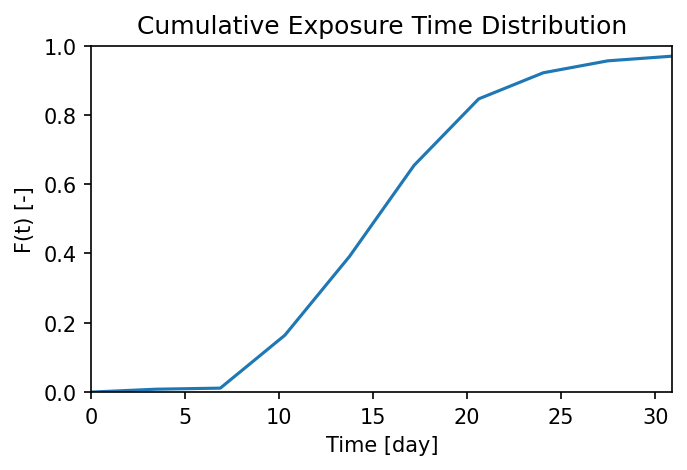

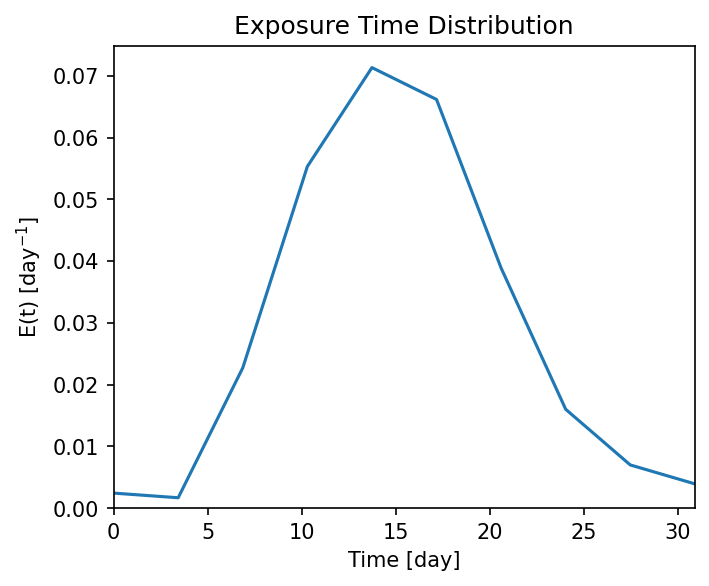

In [15]:
exposure_times_plot = dorado.routines.plot_exposure_time(walk_data, 
                                                         exposure_times, 
                                                         f'{path2folder}/{model_run}/figs', # Output location for figures
                                                         timedelta=86400, # timestep for model in seconds (1 day = 86400 seconds)
                                                         nbins=10, # Binning for CDF exposure time
                                                         uniform_timesteps = True) # This should be toggled to 'True' when the process used in this
                                                                                   # notebook for unsteady data is used. Only toggle this if exposure
                                                                                   # timesteps were discretely assigned. Otherwise use default (False).


**Note:** If any particles are still in the ROI at the end of their travel history, they are excluded from plots. These particles are not done being "exposed," so we need to run more iterations in order to capture the tail of the distribution.

## Save `walk_data` for use with additional model capabilities

If you plan to use extended features of the model, such as reprocessing particle paths, calculating spatial exposure time, or generating animations, be sure to save the `walk_data` dictionary for future use.

**Note:** While this function returns a `walk_data` dictionary, the same information is also stored as an attribute of the `particles` class and can be accessed via `particle.walk_data`.

In [16]:
# json.dump(walk_data, open(data_folder / f'WalkData_{model_run}.txt', 'w')) # Uncomment if new walk_data was created 

Save the following variables if you plan to run spatial exposure time calculations using `spatial.py`, where a walkthrough can be found in `spatial_exposure_time_example_Delft3DFM.ipynb`.

In [17]:
np.savez_compressed(data_folder / f'unstructured_model_Delft3DFM_variables_{model_run}.npz', 
                                                                        elevation=elevation, # rasterized version
                                                                        regions = regions) # region where exposure time was determined

If you have any questions, feel free to contact Caitlin R. R. Turner at cturn65@lsu.edu 

#### **Cited:**
Turner, C. R. R. (2025). Lake Pontchartrain Toy Model, HydroShare, https://doi.org/10.4211/hs.2301e151c62d4febb59655885458ab0c

Turner, C. R. R., & Hiatt, M. (2025a). Water exposure time distributions controlled by freshwater releases in a semi-enclosed estuary. Water Resources Research, 61 (7), e2025WR040287, https://doi.org/10.1029/2025WR040287

Turner, C. R. R., & Hiatt, M. (2025b). Water exposure time distributions controlled by freshwater releases in a semi-enclosed estuary published in water resources research wrr 2025 data. Hydroshare. https://doi:10.4211/hs.f1c83ff830bb47c5a7c84e6f5217ea5c

#### **Acknowledgments:**
This work has been partially supported with funding provided by the Louisiana Sea Grant College Program (LSG) under its Competitive Research Program (Project ID: R/TMA-03) and NOAA Award No. NA18OAR4170098, and through the US Department of Defense/Army Engineer Research and Development Center (ERDC) under Contract No. W912HZ2220005. Additional support was provided from the National Science Foundation (NSF) through Open Earthscape (Collaborative Research: Frameworks: OpenEarthscape - Transformative Cyberinfrastructure for Modeling and Simulation in the Earth-Surface Science Communities) under its Summer Research Scholars Program under award No. 2104102.